<a href="https://colab.research.google.com/github/SnSabu/congressional-analysis/blob/main/Copy_of_Python_Intro_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **The Relationship between Political Parties and Median Age of States**

By Sneha Sabu and Nidhi Athreya Mysore 

February 2023

It is pretty established that the two parties: Republican, and Democrats are the major parties,dominating the political field in USA. These two parties, apart from being political competitors, advocate completely different ideals. 
The Republican Party has generally associated with socially conservative policies, although it does have dissenting centrist and libertarian factions. Social conservatives advocate for laws that uphold traditional family values, often rooted in Christianity. From workers' rights to protecting the environment, equal pay to fighting the special interests, Democrats believe we can and should make life better for families across our nation. fairness, justice, and equality for all by standing up for all middle-class Americans and those struggling to get there. After observing the difference in views and opinions, we wanted to know more about the age brackets of people voting for the above two parties. We wanted to observe whether people of later generations voted largely for Democratic party, as they advocate for a free,liberal USA.
So below is an analysis of the age bracket voting for Republican, Democrats and Libertarian.


**Hypothesis:**  We think that there is a significant difference in ages of people affiliated with different political parties. Our hypothesis is that younger people belonging to the 18-40 age bracket largely vote for Democrats.


**Importing Libraries**

In [35]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas
import seaborn as sns
import scipy.stats as stats

**Data for Median Ages of States**

In [65]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.

url_Median_Age = "https://api.census.gov/data/2021/acs/acs1?get=NAME,B01002_001E,B01002_002E,B01002_003E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url_Median_Age)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here:
# https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Median Age','Male Median Age', 'Female Median Age', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)


In [66]:

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Median Age','Male Median Age', 'Female Median Age', 'district number', 'State']]
# Convert the number columns into number data types so we can do math on them
acs_df["Median Age"] = pd.to_numeric(acs_df["Median Age"])
acs_df["Male Median Age"] = pd.to_numeric(acs_df["Male Median Age"])
acs_df['Female Median Age'] = pd.to_numeric(acs_df['Female Median Age'])

# now let's look at the data again
acs_df.head()

<ipython-input-66-d7723b0755bf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs_df["Median Age"] = pd.to_numeric(acs_df["Median Age"])
<ipython-input-66-d7723b0755bf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs_df["Male Median Age"] = pd.to_numeric(acs_df["Male Median Age"])
<ipython-input-66-d7723b0755bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Median Age,Male Median Age,Female Median Age,district number,State
0,41.1,39.4,42.6,1,Alabama
1,39.2,37.9,40.7,2,Alabama
2,39.4,38.4,40.2,3,Alabama
3,40.7,39.5,42.0,4,Alabama
4,40.3,39.6,41.1,5,Alabama


In [40]:
acs_df['State'].value_counts().head()

California      53
Texas           36
Florida         27
New York        27
Pennsylvania    18
Name: State, dtype: int64

**Data for Party Affiliation of States**

In [38]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)


,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


In [39]:
party_df['State'].value_counts().head()

California      53
Texas           36
New York        27
Florida         27
Pennsylvania    18
Name: State, dtype: int64

**Merging Median Age with Party Data**

In [41]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [42]:
merged_df.head()

,Median Age,Male Median Age,Female Median Age,district number,State,Party
0,41.1,39.4,42.6,1,Alabama,R
1,39.2,37.9,40.7,2,Alabama,R
2,39.4,38.4,40.2,3,Alabama,R
3,40.7,39.5,42.0,4,Alabama,R
4,40.3,39.6,41.1,5,Alabama,R


In [43]:
#Checking whether the State names are unique
merged_df['State'].nunique()

50

In [44]:
#Sorting out the data of median ages:

merged_df.sort_values(by = ['Male Median Age', 'Female Median Age'], ascending = [True, True], na_position = 'first').head(10)

,Median Age,Male Median Age,Female Median Age,district number,State,Party
399,29.4,28.9,30.2,3,Utah,R
41,30.6,30.8,30.3,21,California,D
36,31.8,30.9,32.6,16,California,D
14,31.2,31.0,31.4,7,Arizona,D
375,32.0,31.0,33.2,15,Texas,D
388,32.6,31.1,34.7,28,Texas,D
400,31.6,31.3,32.0,4,Utah,D
397,31.8,31.4,32.3,1,Utah,R
376,32.9,31.5,34.5,16,Texas,D
271,33.8,31.5,35.8,15,New York,D


In [45]:
#Merging the above two datasets:

merged_df.sort_values(by = ['Male Median Age', 'Female Median Age'], ascending = [False, False], na_position = 'first').head(10)

,Median Age,Male Median Age,Female Median Age,district number,State,Party
97,55.4,53.4,57.1,11,Florida,R
103,53.9,52.5,55.1,17,Florida,R
105,51.8,50.7,52.8,19,Florida,R
104,48.7,47.1,50.0,18,Florida,R
92,48.9,46.9,50.5,6,Florida,R
99,48.4,46.9,49.7,13,Florida,D
94,48.9,46.6,50.5,8,Florida,R
11,48.5,46.2,49.9,4,Arizona,R
198,47.1,45.2,48.6,1,Michigan,R
197,46.5,44.9,48.3,9,Massachusetts,D


**Median Age Distributition**

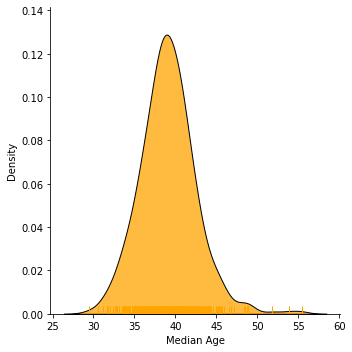

In [57]:
sns.displot(merged_df, x="Median Age", kind = "kde", color = "orange", rug = True, multiple="stack")


**Median Age vs Political Affiliation**

Text(0.5, 1.0, 'Median Age by Party')

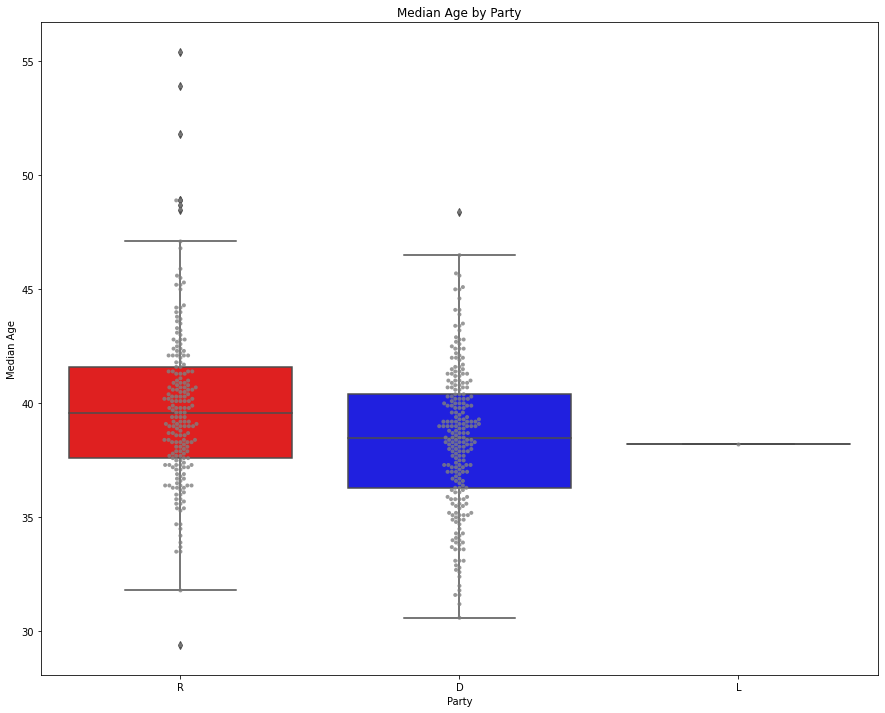

In [88]:
#Plotting a graph for the three parties:

plt.figure(figsize=(15,12))
party_colors=['#FF0000', '#0000FF','#FFFF00']
sns.set_palette(party_colors)
sns.boxplot(x='Party', y='Median Age',data=merged_df)
sns.swarmplot(x='Party', y='Median Age',data=merged_df, dodge='True', color='grey', alpha=.8, s=4)
plt.title("Median Age by Party")

The graph showed us that people belonging to 25-40 age bracket mostly voted for democrats, and people who were 45 plus, voted in maximum for the republican party.  

**Anova Statistical Test**

In [52]:
# Perform the one-way ANOVA test for statistical significance :

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
f_value, p_value = stats.f_oneway(merged_df['Median Age'][merged_df['Party'] == 'R'],
               merged_df['Median Age'][merged_df['Party'] == 'D'],
               merged_df['Median Age'][merged_df['Party'] == 'L'])
print(f_value, p_value)

#f_value, p_value = stats.f_oneway(party_a, party_b, party_c)

# Print the results
print("F-value: ", f_value)
print("P-value: ", p_value)

# Check if the results are statistically significant
alpha = 0.05
if p_value < alpha:
    print("The results are statistically significant (p < 0.05). Reject the null hypothesis")
else:
    print("The results are not statistically significant (p >= 0.05). Retain the null hypothesis")


9.478092036200367 9.364193601029661e-05
F-value:  9.478092036200367
P-value:  9.364193601029661e-05
The results are statistically significant (p < 0.05).


**Confounding Variables**

***Participation of citizens:*** People from the older generation might not be participating in the elections and those who place their votes might be largly voting for one party. This will skew the results drastically.

In [76]:
merged_df['Median Age Buckets'] = pd.cut(merged_df['Median Age'], [0,21,37,53,72,110], labels=("Generation Z","Millenial", "Generation X", "Baby Boomer", "Silent Generation"))
merged_df.groupby('Median Age Buckets').size()

Median Age Buckets
Generation Z           0
Millenial            110
Generation X         323
Baby Boomer            2
Silent Generation      0
dtype: int64

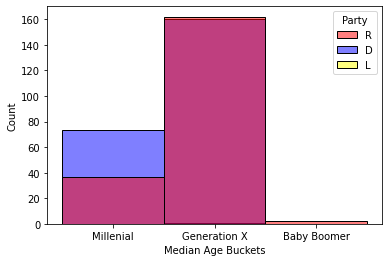

In [80]:
colors = {'R': '#FF0000', 'D': '#0000FF','L':'#FFFF00'}
sns.histplot(data=merged_df, x="Median Age Buckets", hue = 'Party',binwidth=3, palette = colors)

***Gender:*** People from one gender might be mainly from one age group and they might also be affined to a particular political party. This can skew the results

In [84]:
merged_df['Female Median Age Buckets'] = pd.cut(merged_df['Female Median Age'], [0,21,37,53,72,110], labels=("Generation Z","Millenial", "Generation X", "Baby Boomer", "Silent Generation"))
merged_df.groupby('Female Median Age Buckets').size()


Female Median Age Buckets
Generation Z           0
Millenial             80
Generation X         353
Baby Boomer            2
Silent Generation      0
dtype: int64

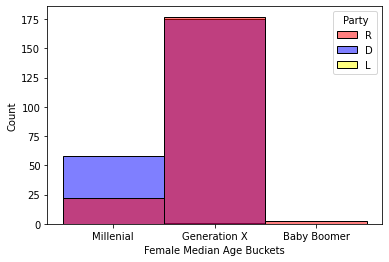

In [85]:
colors = {'R': '#FF0000', 'D': '#0000FF','L':'#FFFF00'}
sns.histplot(data=merged_df, x="Female Median Age Buckets", hue = 'Party',binwidth=3, palette = colors)

In [83]:

merged_df['Male Median Age Buckets'] = pd.cut(merged_df['Male Median Age'], [0,21,37,53,72,110], labels=("Generation Z","Millenial", "Generation X", "Baby Boomer", "Silent Generation"))
merged_df.groupby('Male Median Age Buckets').size()

Male Median Age Buckets
Generation Z           0
Millenial            165
Generation X         269
Baby Boomer            1
Silent Generation      0
dtype: int64

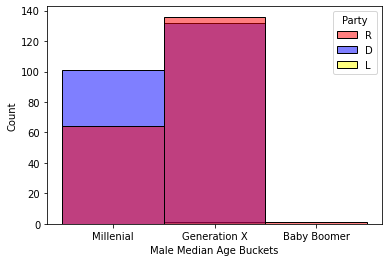

In [86]:
colors = {'R': '#FF0000', 'D': '#0000FF','L':'#FFFF00'}
sns.histplot(data=merged_df, x="Male Median Age Buckets", hue = 'Party',binwidth=3, palette = colors)

Our initial hypothesis was to check whether people of ages who voted for democrats maximally, irrespective of gender, belonged to 25-40 age bracket. We wanted to test this hypothesis as people voting for democrats generally belong to a more liberal sense of thought, and belong to later generations. To test this hypothesis, we explored the median-age dataset. We cleaned the data, later bucketed the median ages into five groups. The graph showed us that people belonging to 25-40 age bracket mostly voted for democrats, and people who were 45 plus, voted in maximum for the republican party. But we conducted the ANOVA test, we saw that the p-value<0.05 thus, we reject the null hypothesis. Thus,we can conclude that there is a statistically significant difference between the groups and their median ages. People of 25-40 age bracket necessarily do not largely vote for Democrats. Inevitably, this forces us to ask more questions, and perform more analysis. First, our concern is whether all the people of age vote. If there is a significantly large amount of people not voting, then it would directly affect both the age bracket we have assumed, and also decide the leading party in USA. This leads us to believe that the confounder variable is voting awareness amongst the youth and amongst the elderly.


**Data Sources:** 

For median age data:
https://www.census.gov/data/developers/data-sets/acs-1year.html

For party data:
http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv

For Anova Test: https://www.pythonfordatascience.org/anova-python/
